## Attention scores

What relationships exists between pairwise attention scores and pairwise distances?

In [35]:
import sys
sys.path.append('..')

import os
import random

import numpy as np

import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from models.biased_attention_transformer import BiasedAttentionTransformer
from data import PointCloudDataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model = BiasedAttentionTransformer(
    n_tokens=6, 
    out_features=2, 
    E=64, H=8, D=8, 
    dropout=0.1, 
    radial_function_type="PowerLaw"
)
model_file = "/scratch/midway3/jshe/molecular-attention-bias/U_G/BiasedAttentionTransformer/PowerLaw/E64H8D8/202508061841171/model.pt"
state_dict = torch.load(model_file, map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval();

In [3]:
dataset = PointCloudDataset(
    atoms_file = "/scratch/midway3/jshe/data/qm9/scaffolded/validation/atoms.npy",
    coordinates_file = "/scratch/midway3/jshe/data/qm9/scaffolded/validation/coordinates.npy",
    y_file = "/scratch/midway3/jshe/data/qm9/scaffolded/validation/y.npy",
    y_labels_file = "/scratch/midway3/jshe/data/qm9/transformed/y_labels.npy",
    y_mean_file = "/scratch/midway3/jshe/data/qm9/transformed/y_mean.npy", 
    y_std_file = "/scratch/midway3/jshe/data/qm9/transformed/y_std.npy", 
    target_labels = ['U', 'G']
)
dataloader = DataLoader(
    dataset, batch_size=64, shuffle=True, 
    num_workers=4, persistent_workers=True, pin_memory=True, 
    collate_fn=dataset.collate
)


In [54]:
tokens, padding, r, y = next(iter(dataloader))
B, L, _ = r.shape
model(tokens, padding, r, hook=True);

In [ ]:

d = torch.norm(
    r.unsqueeze(1) - r.unsqueeze(2), 
    dim=-1
).unsqueeze(1).expand(B, 8, L, L)
mask = torch.logical_and(d != 0, d < 1e8)
d = d[mask]

indices = torch.tensor(random.sample(range(len(d)), 512))
sample_d = d[indices]

## Attention Logits

In [27]:
qkt = model.transformer_blocks[0].attn.hook['qkt']
qkt = qkt[mask]
sample_qkt = qkt[indices].numpy()

attn_bias = model.transformer_blocks[0].attn.hook['attn_bias']
attn_bias = attn_bias[mask]
sample_attn_bias = attn_bias[indices].numpy()

attn_logits = model.transformer_blocks[0].attn.hook['attn_logits']
attn_logits = attn_logits[mask]
sample_attn_logits = attn_logits[indices].numpy()

/home/jshe/ipykernel_3639572/3775576890.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax0.legend()


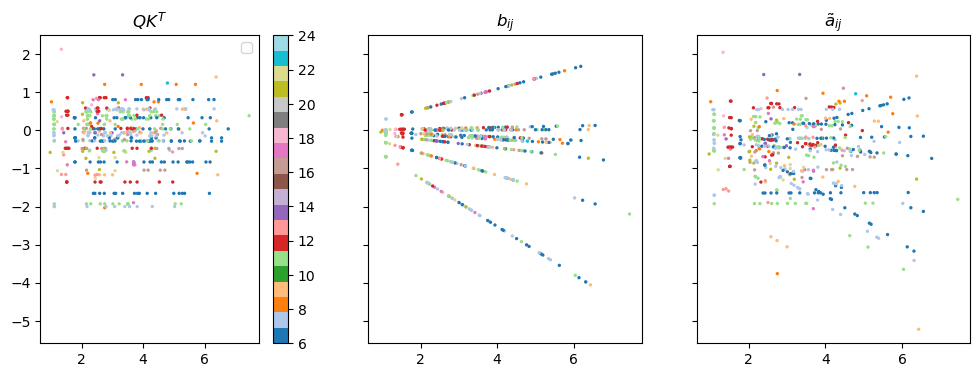

In [64]:
cmap = plt.get_cmap('tab20')

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

cbar = ax0.scatter(sample_d, sample_qkt, s=2, c=sample_pair_types, cmap=cmap)
ax0.set_title('$QK^T$')
ax1.scatter(sample_d, sample_attn_bias, s=2, c=sample_pair_types, cmap=cmap)
ax1.set_title('$b_{ij}$')
ax2.scatter(sample_d, sample_attn_logits, s=2, c=sample_pair_types, cmap=cmap)
ax2.set_title(r'$\tilde{a}_{ij}$')

fig.colorbar(cbar, ax=ax0)
ax0.legend()

In [ ]:






attn_bias = model.transformer_blocks[0].attn.attn_bias
attn_bias = attn_bias[mask]

attn_logits = model.transformer_blocks[0].attn.attn_logits
attn_logits = attn_logits[mask]

attn_probs = model.transformer_blocks[0].attn.attn
attn_probs = attn_probs[mask]

In [ ]:

sample_d = d[indices].numpy()

sample_attn_bias = attn_bias[indices].numpy()
sample_attn_logits = attn_logits[indices].numpy()
sample_attn_probs = attn_probs[indices].numpy()

Text(0.5, 1.0, '$a_{ij}$')

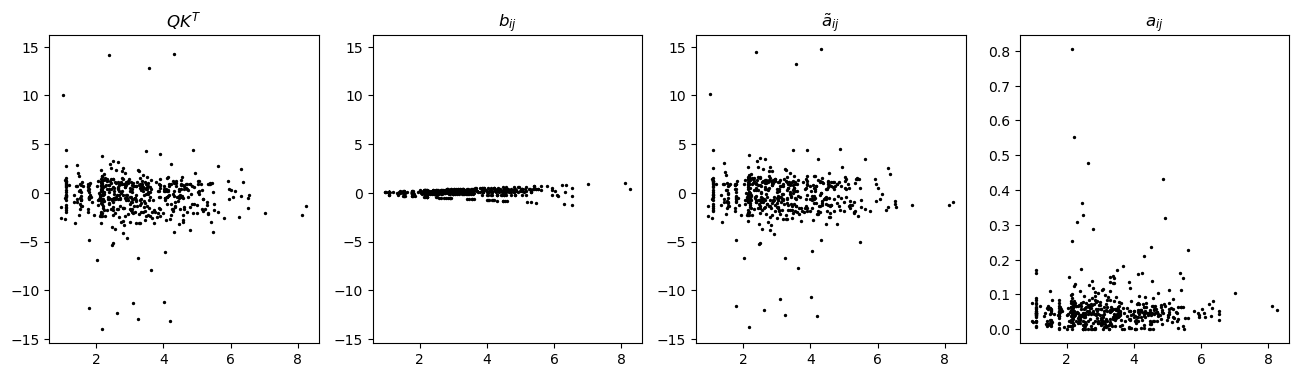

In [ ]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(16, 4))

ax0.sharey(ax1)
ax1.sharey(ax2)

ax0.scatter(sample_d, sample_qkt, s=2, color='k')
ax0.set_title('$QK^T$')
ax1.scatter(sample_d, sample_attn_bias, s=2, color='k')
ax1.set_title('$b_{ij}$')
ax2.scatter(sample_d, sample_attn_logits, s=2, color='k')
ax2.set_title(r'$\tilde{a}_{ij}$')
ax3.scatter(sample_d, sample_attn_probs, s=2, color='k')
ax3.set_title('$a_{ij}$')